<h1> Simple image segmentation </h1>

In this notebook, I will attempt image segmentation using basic filtering, masking and thresholding techniques.

The results will be compared with the Otsu method from the OpenCV library. For a comparison with a neural network solution, see `img_segment_nn.ipynb`.

In [28]:
# Import statements
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import impro_utils as imp

plt.rcParams.update({'font.size': 40})

<h3> Loading data </h3>

Here we are loading the classic photographer image and a cat image. We would like to isolate the photographer in one image, and the background in another, and same with the cat.

This is actually quite a complicated problem, as the background has many high contrast features similar to the foreground. Both images are quite different in complexity, so we will start with the cat, then the photographer, to show the limitations of this technique.

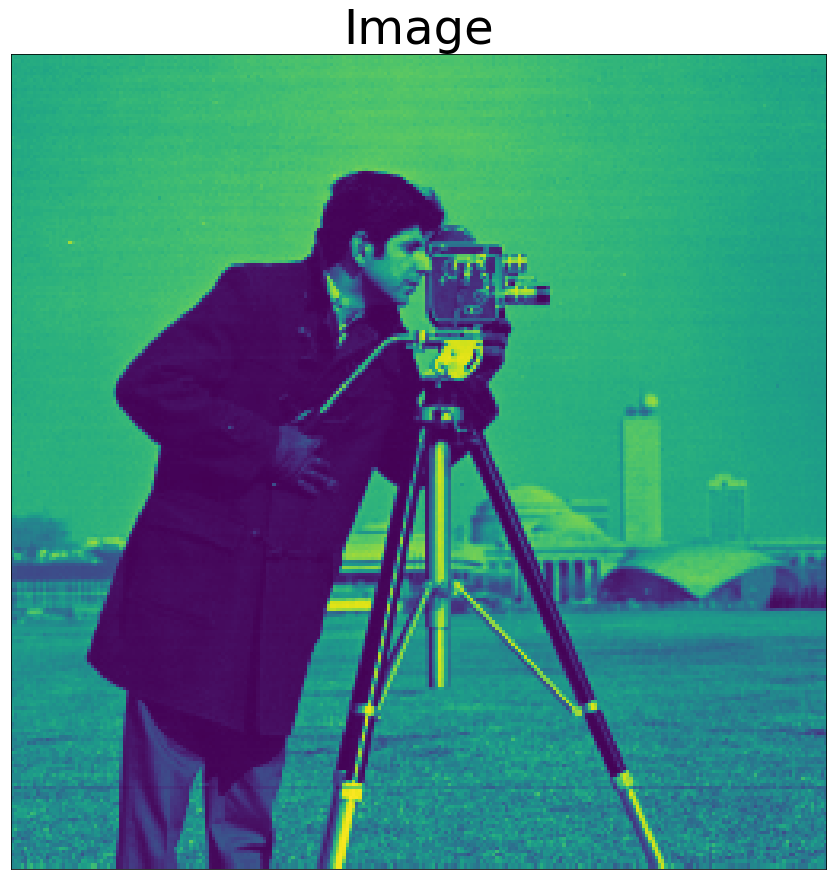

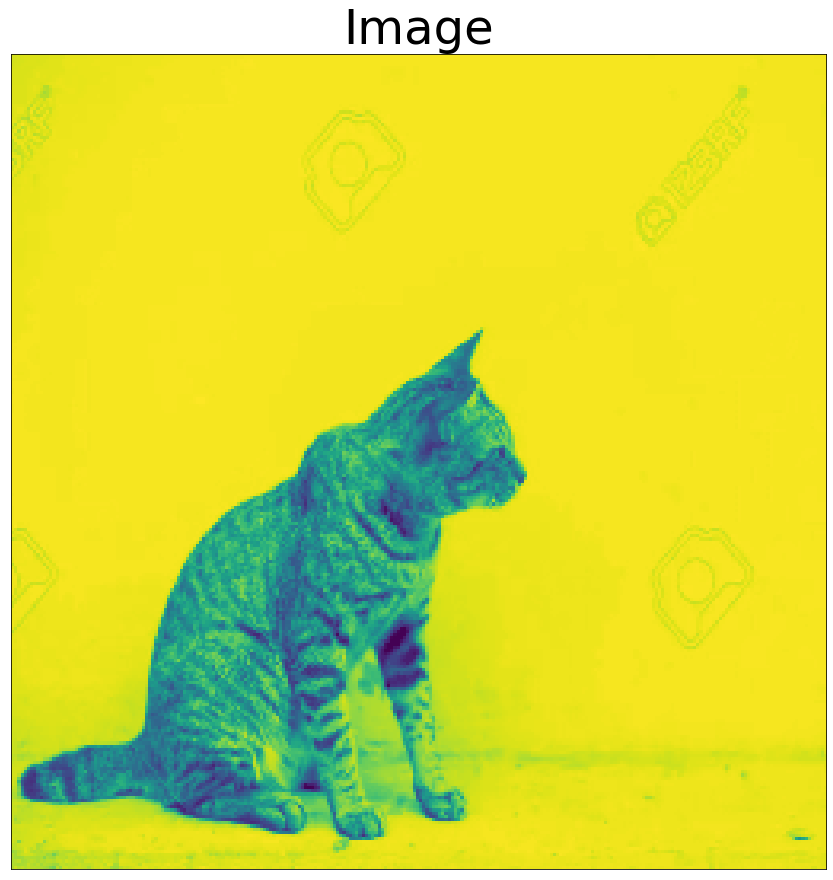

In [8]:
filename = 'images/test2.jpg'
image = imp.load_data(filename)

filename = 'images/cat.png'
cat = cv.resize(imp.load_data(filename),(256,256))

fig = plt.figure(figsize=(20,15))
imp.plot_img(image, "Image")

fig = plt.figure(figsize=(20,15))
imp.plot_img(cat, "Image")

<h3> Creating mask based on thresholding </h3>

Generally, image segmentation is based on the concept of thresholding. Picture a grate that only allows certain elements to pass through. Enlarging the grate hole size will allow larger (more) objects in, and the opposite restricts the entry to smaller objects (fewer). Determining the proper thresholding is non-trivial; several algorithms have been developed to automate image segmentation, one of which is Otsu's method, which we will see in the next section.

A quick and dirty way to isolate different features with high contrast is to use thresholding.

A thresholding mask uses a logical operation to isolate features based on their pixel value. The function `img_mask` in the `impro_utils.py` function creates a mask that is True for values less than a certain value and False otherwise. The logical mask can then be used in a matrix operation with the original image. Here, we perform an element-wise multiplication to lose all background components (False) and keep foreground components (True).

Playing around with the `threshold` variable will give different results!

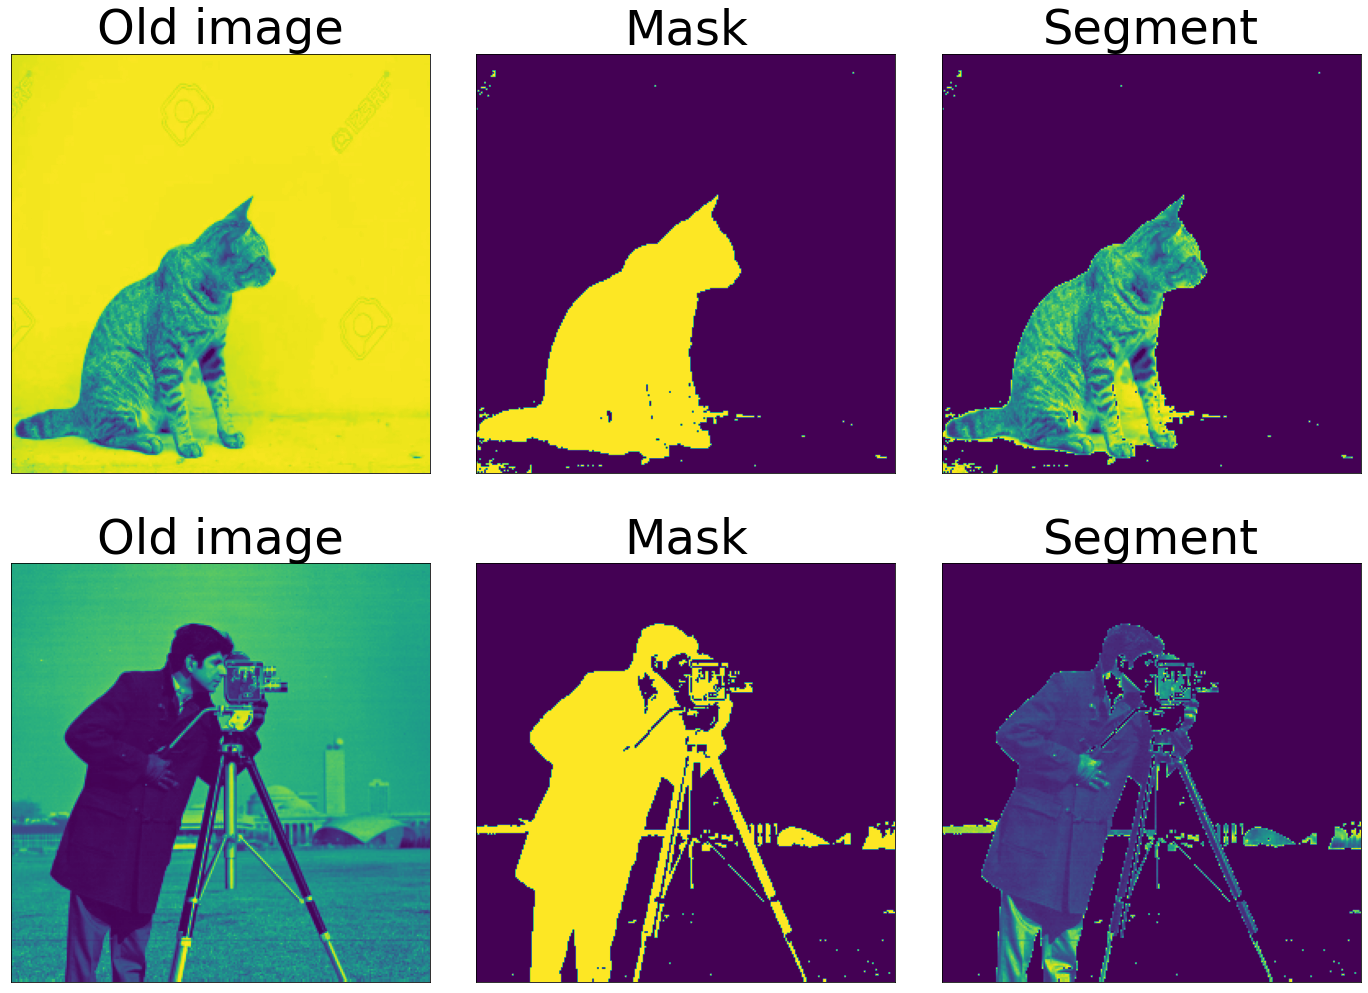

In [39]:
mask = imp.img_mask(cat, threshold=0.9)

fig = plt.figure(figsize=(20,15))
plt.subplot(2,3,1)
imp.plot_img(abs(cat),'Old image')
plt.subplot(2,3,2)
imp.plot_img(abs(mask),'Mask')
plt.subplot(2,3,3)
imp.plot_img(abs(mask*cat),'Segment')

mask = imp.img_mask(image, threshold=0.3)

plt.subplot(2,3,4)
imp.plot_img(abs(image),'Old image')
plt.subplot(2,3,5)
imp.plot_img(abs(mask),'Mask')
plt.subplot(2,3,6)
imp.plot_img(abs(mask*image),'Segment')
plt.tight_layout()

This worked... kind of. We got the photographer outline, but we're missing their face and we have some background elements in the image. The cat image also still has some of the background mixed in the foreground. We can do better than this.

Let's try blurring our image to smear some of the high contrast features.

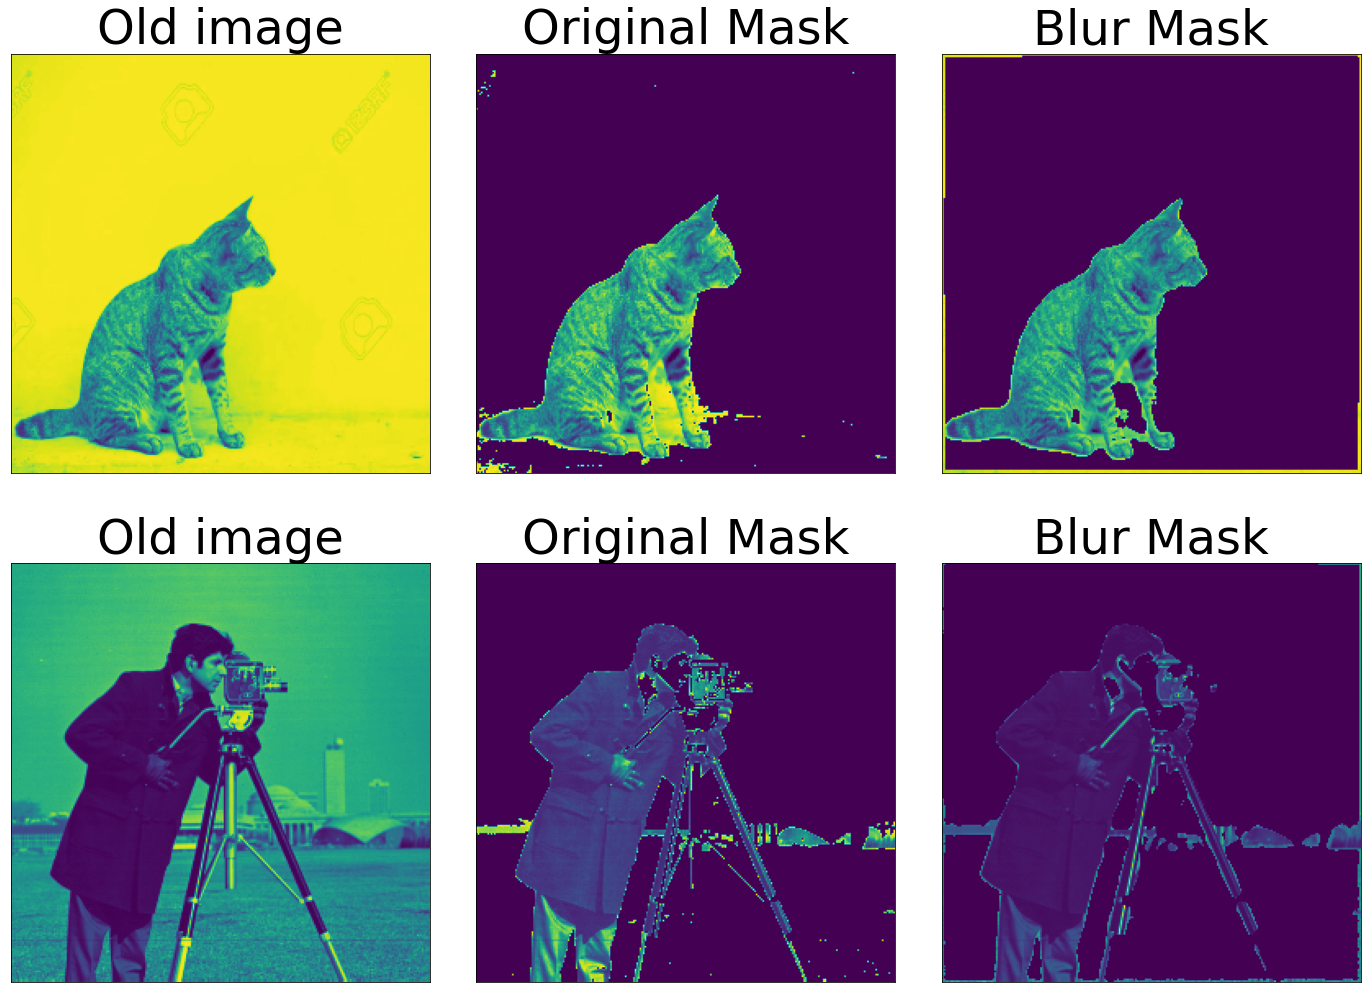

In [38]:
mask = imp.img_mask(cat, threshold=0.9)
mask_blur = imp.img_mask(imp.low_pass_gauss(cat,4), threshold=0.8)

fig = plt.figure(figsize=(20,15))
plt.subplot(2,3,1)
imp.plot_img(abs(cat),'Old image')
plt.subplot(2,3,2)
imp.plot_img(abs(mask*cat),'Original Mask')
plt.subplot(2,3,3)
imp.plot_img(abs(mask_blur*cat),'Blur Mask')

mask = imp.img_mask(image, threshold=0.3)
mask_blur = imp.img_mask(imp.low_pass_gauss(image,4), threshold=0.4)

plt.subplot(2,3,4)
imp.plot_img(abs(image),'Old image')
plt.subplot(2,3,5)
imp.plot_img(abs(mask*image),'Original Mask')
plt.subplot(2,3,6)
imp.plot_img(abs(mask_blur*image),'Blur Mask')
plt.tight_layout()

That helped with getting rid of some of the specks, but we still have some background contamination in the photographer image. In the cat image, it worked near-flawlessly but the image boundary is highlighted due to the smearing. We will see that this works comparable to the more advanced Otsu method.

<h3> Otsu's Method </h3>

Otsu's method uses an algorithm to determine the threshold value that minimizes the weighted within-class variance. What does that mean? Say we plot all the pixel values of a grayscale image as a histogram. We would end up with some Gaussian-like distribution. Ideally, we would have two distributions (classes): one being for the foreground (higher intensity), the other being for the background (lower intensity). The width of a Gaussian is its variance; Otsu's algorithm attempts to locate a value that minimizes the variances of both image classes such that we are able to segment them effectively.

Often, a Gaussian blur filter is applied to increase the probability of success. Blur filters reduce the apparent noise in an image which is why they are often used.

Note: the negation of the Otsu mask is used because we want the foreground, not the background.

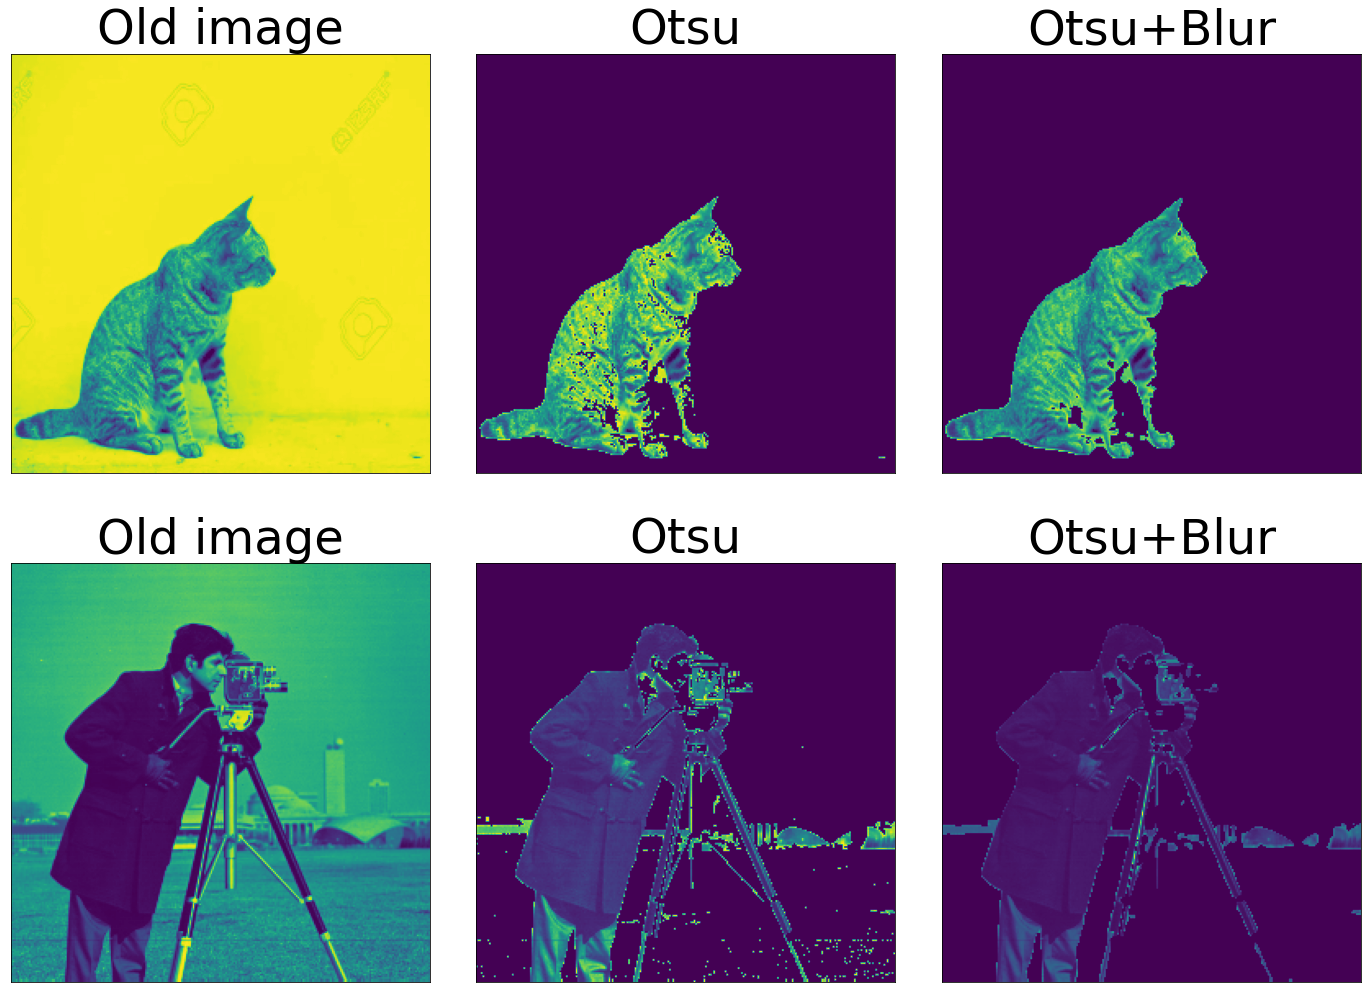

In [36]:
_,otsu = cv.threshold(cat, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

blur = cv.GaussianBlur(cat,(5,5),0)
_,otsu_blur = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

fig = plt.figure(figsize=(20,15))
plt.subplot(2,3,1)
imp.plot_img(abs(cat),'Old image')
plt.subplot(2,3,2)
imp.plot_img(abs((~otsu>200)*cat),'Otsu')
plt.subplot(2,3,3)
imp.plot_img(abs((~otsu_blur>200)*cat),'Otsu+Blur')

_,otsu = cv.threshold(image, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

blur = cv.GaussianBlur(image,(5,5),0)
_,otsu_blur = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

plt.subplot(2,3,4)
imp.plot_img(abs(image),'Old image')
plt.subplot(2,3,5)
imp.plot_img(abs((~otsu>200)*image),'Otsu')
plt.subplot(2,3,6)
imp.plot_img(abs((~otsu_blur>200)*image),'Otsu+Blur')
plt.tight_layout()


Not too bad! There are still some background elements, but this is a hard problem to solve.

Otsu performed much better with the cat image versus the photographer. This is because the cat had very high contrast with the background, which makes it easier to threshold. The photographer on the other hand, had similar pixel intensity to some of the background therefore was not able to be fully thresholded out. This kind of ambiguity can be solved by neural networks that are trained well! See `img_segment_nn.ipynb` for this implementation.

Just goes to show that sometimes simple methods work better than complicated ones!

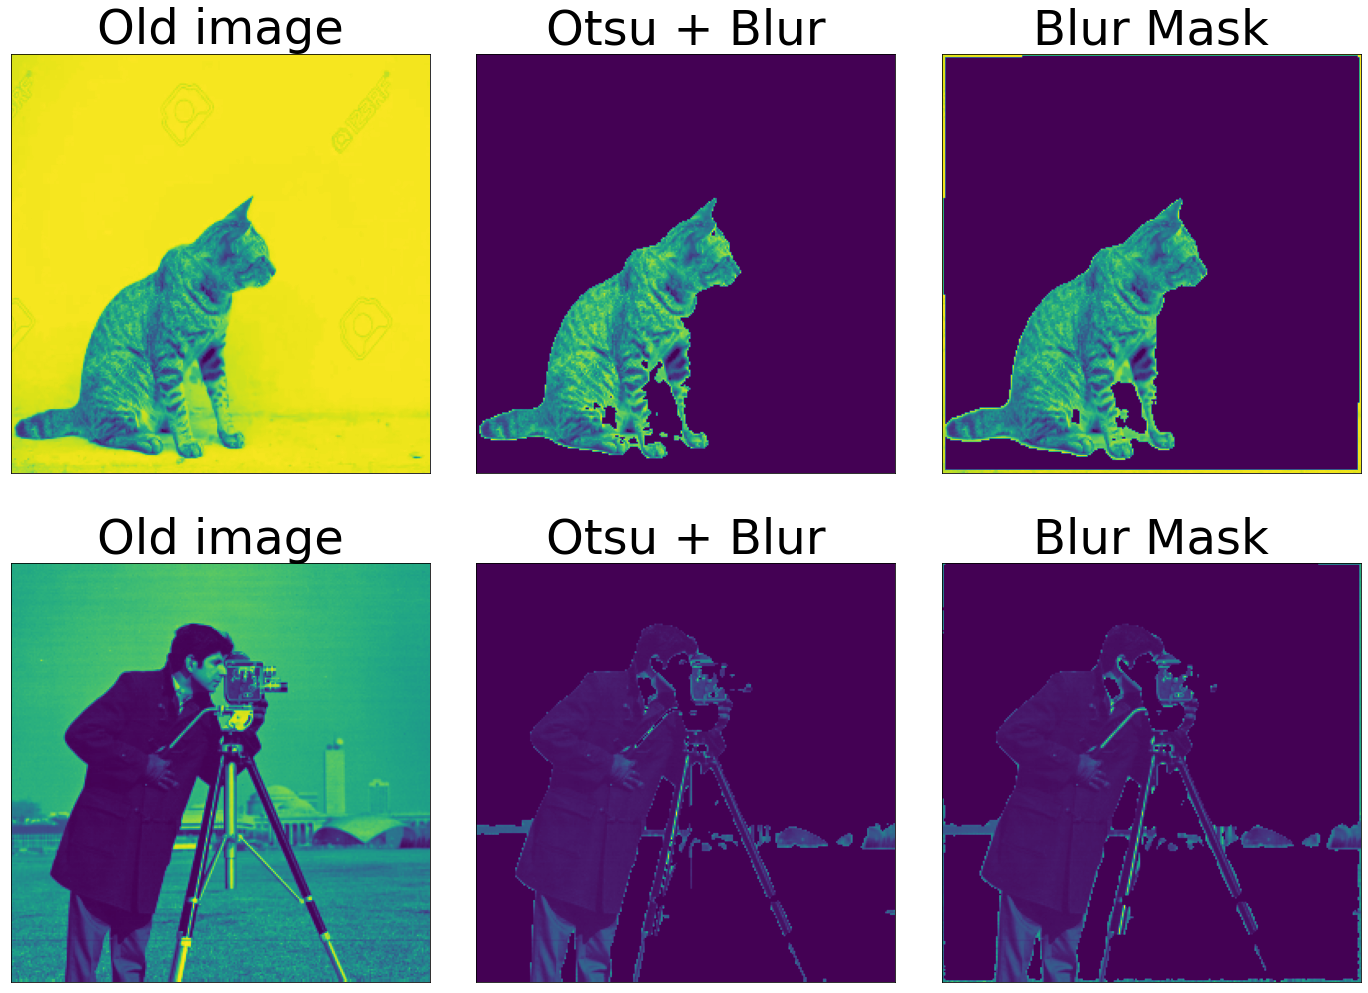

In [40]:
mask = imp.img_mask(cat, threshold=0.3)
mask_blur = imp.img_mask(imp.low_pass_gauss(cat,4), threshold=0.8)

blur = cv.GaussianBlur(cat,(5,5),0)
_,otsu_blur = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

fig = plt.figure(figsize=(20,15))
plt.subplot(2,3,1)
imp.plot_img(abs(cat),'Old image')
plt.subplot(2,3,2)
imp.plot_img(abs((~otsu_blur>200)*cat),'Otsu + Blur')
plt.subplot(2,3,3)
imp.plot_img(abs(mask_blur*cat),'Blur Mask')

mask = imp.img_mask(image, threshold=0.3)
mask_blur = imp.img_mask(imp.low_pass_gauss(image,4), threshold=0.4)

blur = cv.GaussianBlur(image,(5,5),0)
_,otsu_blur = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

plt.subplot(2,3,4)
imp.plot_img(abs(image),'Old image')
plt.subplot(2,3,5)
imp.plot_img(abs((~otsu_blur>200)*image),'Otsu + Blur')
plt.subplot(2,3,6)
imp.plot_img(abs(mask_blur*image),'Blur Mask')
plt.tight_layout()